In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import warnings

In [2]:
data_file_formats = [
    ("data/960_seed0_Bo120_qweninst_mistral/", "qwen_instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Llama-3.1-8B-Instruct_RM-Mistral-7B/", "Llama-3.1-8B-Instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Llama-3.2-3B-Instruct_RM-Mistral-7B/", "Llama-3.2-3B-Instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Ministral-8B-Instruct-2410_RM-Mistral-7B/", "Ministral-8B-Instruct-2410_RM-Mistral-7B_prompt_"),
]

In [3]:
data = []
prompt_size = 100
for item in data_file_formats:
    all_x = []
    prefix = item[0] + item[1]
    for i in range(prompt_size):
        index = i
        trajectories = []
        try:
            file_name = prefix + str(index).zfill(4) + ".json"

            import json
            with open(file_name, "r") as f:
                row = json.load(f)
                
                for x in row:
                    trajectories.extend(x["trajectories"])
    #             prompt_data.append(trajectories)
        except:
            pass
        
        x = [y["score"] for y in trajectories]
        all_x.append(x)

    df_real = pd.DataFrame(all_x)
    df_real.shape
    data.append(df_real)

In [ ]:
def get_cap_value(cdf, cost, estimated_max):
    l = 0
    u = 1e12
    eps = 0.001
    for i in range(100):
        m = (l+u)/2
        if 1-cdf(m) < eps:
            u = m
        else:
            l = m

    exp_max = estimated_max
    up = u
    eps = 1e-2
    tot = 0
    tot_density = 0
    while up > eps:
        z = cdf(up*(1-eps))
        dy = cdf(up) - z
        up = up*(1-eps)
        v = up/(up+exp_max)
        tot += v*dy
        tot_density += dy
        if tot-tot_density*v >= cost:
            return v
    return 0

def get_max_value(cdf):
    l = 0
    u = 1e12
    eps = 0.001
    for i in range(100):
        m = (l+u)/2
        if 1-cdf(m) < eps:
            u = m
        else:
            l = m
    return u

In [5]:

DISTRIBUTIONS_TO_TEST = {
#     "Gaussian (Normal)": stats.norm,
#     "Exponential": stats.expon,
    "Log-Normal": stats.lognorm,
#     "Gamma": stats.gamma,
#     "Beta": stats.beta,
#     "Weibull": stats.weibull_min, # or stats.weibull_max
    "Pareto": stats.pareto
}

# --- Core Fitting Function ---

def find_best_distribution(data, distributions=DISTRIBUTIONS_TO_TEST, use_aic_bic=True):
    results = []
    best_metric = np.inf
    best_dist_name = None
    best_params = None

    # Ensure data is a numpy array
    data = np.asarray(data)
    n_data = len(data)

    for name, distribution in distributions.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if name == "Log-Normal" or name == "Pareto":
                    params = distribution.fit(data, floc=0)
                else:
                    params = distribution.fit(data)
            ks_stat, ks_p_value = stats.kstest(data, distribution.name, args=params)

            log_likelihood = np.sum(distribution.logpdf(data, *params))
            k_params = len(params) # Number of parameters estimated
            aic = 2 * k_params - 2 * log_likelihood
            bic = k_params * np.log(n_data) - 2 * log_likelihood

            # Store results
            results.append({
                "Distribution": name,
                "Parameters": params,
                "KS Statistic (D)": ks_stat,
                "KS p-value": ks_p_value,
                "Log-Likelihood": log_likelihood,
                "AIC": aic,
                "BIC": bic
            })

            # --- 4. Update Best Fit ---
            current_metric = aic if use_aic_bic else ks_stat # Choose metric for ranking
            if current_metric < best_metric:
                best_metric = current_metric
                best_dist_name = name
                best_params = params

        except Exception as e:
            results.append({
                "Distribution": name,
                "Parameters": None,
                "KS Statistic (D)": np.nan,
                "KS p-value": np.nan,
                "Log-Likelihood": np.nan,
                "AIC": np.nan,
                "BIC": np.nan
            })

    if not results:
         return None, None, pd.DataFrame()

    # Create DataFrame for nice output
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AIC" if use_aic_bic else "KS Statistic (D)")

    # Determine final best based on the chosen metric after processing all
    if not results_df.empty:
        best_row = results_df.iloc[0]
        final_best_dist_name = best_row["Distribution"]
        final_best_params = best_row["Parameters"]
        best_fit_dist = DISTRIBUTIONS_TO_TEST[final_best_dist_name](*final_best_params)
    else:
        final_best_dist_name = None
        final_best_params = None
        best_fit_dist = None

    return final_best_dist_name, final_best_params, results_df, best_fit_dist

In [8]:
def pandoras_box(data, costs):
    n = np.min([d.shape[0] for d in data])
    max_until = {
        "value": -10,
        "generator": 0,
        "index": 0
    }
    m = len(data)
    
    min_open_count = 10
    
    open_count = [min_open_count for i in range(m)]
    for i in range(m):
        for j in range(min_open_count):
            if data[i][j] > max_until["value"]:
                max_until = {
                    "value": data[i][j],
                    "generator": i,
                    "index": j
                }
    
    global_opt = {
        "value": -10,
        "generator": 0,
        "index": 0
    }
    for i in range(m):
        for j in range(data[i].shape[0]):
            if data[i][j] > global_opt["value"]:
                global_opt = {
                    "value": data[i][j],
                    "generator": i,
                    "index": j
                }
                
    global_max = np.max([np.max(data[i]) for i in range(m)])
    flag = True
    while True:
        cap_values = []
        estimated_max = 0
        
        estimated_dists = []
        
        for i in range(m):
            if open_count[i] == len(data[i]):
                continue
                
            row = data[i]
            
            sample = np.exp(row[:open_count[i]+1])
            eps = 1/n
            multiplier = (1 + max((n/4-open_count[i])/(n/4),0))**3
            sample = sample * multiplier
    
#             dist_name, params, _, dist = find_best_distribution(sample)
            dist_name = "Log-Normal"
            params = stats.lognorm.fit(sample, floc=0)
            dist = stats.lognorm(*params)
            
            estimated_dists.append((dist, i))
    
            exp_max = get_max_value(dist.cdf)
            estimated_max = max(exp_max, estimated_max)
        
        for dist, i in estimated_dists:
            c = get_cap_value(dist.cdf, costs[i], estimated_max)
            cap_values.append((c, i))
            
        if len(cap_values) == 0:
            break
            
        v = np.exp(max_until["value"])
#         print("==>", v, estimated_max)
        
        v = v/(v + estimated_max)
        cap_values = sorted(cap_values, reverse=True)
        
#         print(v, cap_values[0], estimated_max, np.exp(global_opt["value"]))
        
        if cap_values[0][0] < v:
            break
        else:
            i = cap_values[0][1]
            if data[i][open_count[i]] > max_until["value"]:
                max_until["value"] = data[i][open_count[i]]
                max_until["generator"] = i
                max_until["index"] = open_count[i] 
            
            open_count[i] += 1
            
    return {
        "dist_name": dist_name,
        "exp_score": np.exp(max_until["value"]),
        "open_count": open_count,
        "score": max_until["value"],
        "opt": global_max,
        "exp_opt": np.exp(np.max(global_max)),
        "win_rate": np.exp(max_until["value"])/(np.exp(max_until["value"]) + np.exp(global_max)),
        "max_until": max_until,
        "global_opt": global_opt
    }
    
def call_single_box_pandoras_box(df, index, cost):
    x = [np.array(df.iloc[index])]
    costs = [cost]
    return pandoras_box(x, costs)

In [12]:
np.random.seed(42)

for c in [0.05, 0.04, 0.03, 0.02, 0.010, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001]:
    print(c)
    generator_id = 0
    results = []
    import tqdm
    epoch = 1
    for e in range(epoch):
        for i in tqdm.tqdm(range(100)):
    #         d = np.array(df_real.iloc[i])
    #         np.random.shuffle(d)
            out = call_single_box_pandoras_box(data[generator_id], i, c)
            results.append(out)
            
    avg_stop_time = int(np.mean([x["open_count"][0] for x in results]))

    print(np.mean([x["win_rate"] for x in results]), np.median([x["win_rate"] for x in results]), np.mean([x["open_count"][0] for x in results]))
    
    wins = []
    df_real = data[generator_id]
    for i in range(100):
        d = np.exp(df_real.iloc[i])
        v = np.max(d[:avg_stop_time])
        m = np.max(d)
        wins.append(v/(v+m))
    print(np.mean(wins), np.median(wins))
    
    with open(f"res_{c}.json", "w") as f:
        json.dump(results, f)

0.05


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


0.15135746892616522 0.13213050767400503 13.1
0.1523859524563399 0.11920292202211755
0.04


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


0.17151930217999323 0.15103053298229968 15.29
0.16181247144528726 0.13847231975815127
0.03


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


0.1934840558585347 0.18477910298439149 20.43
0.1829517276545762 0.16451646289656313
0.02


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


0.24896938306634653 0.2407774880240356 40.12
0.23123057263971433 0.2147031627020839
0.01


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


0.31248081845580494 0.30735801686526387 79.52
0.28817090640132975 0.28140560742914383
0.009


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


0.31970363971593047 0.30735801686526387 84.8
0.2926688342900768 0.2845867115950985
0.008


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


0.3215973767025953 0.30735801686526387 89.83
0.3027261035866097 0.29421497216298875
0.007


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


0.32514220821170925 0.320821300824607 96.13
0.30974989437482825 0.30735801686526387
0.006


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


0.32790970613865367 0.3277053710388965 101.89
0.31605700199503817 0.31070428092853564
0.005


100%|██████████| 100/100 [03:25<00:00,  2.06s/it]


0.33699367541277225 0.3451138173861314 108.77
0.31619822116473 0.31070428092853564
0.004


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


0.34606806596089684 0.35577489351363034 116.32
0.32670665053100933 0.334589441253186
0.003


100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


0.3472518227506387 0.3593720495166236 123.19
0.33030087026237437 0.334589441253186
0.002


100%|██████████| 100/100 [03:43<00:00,  2.24s/it]


0.3504800618568206 0.36296920551961676 135.48
0.34463734372419635 0.3522100144237881
0.001


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


0.36425644165940474 0.3775406687981454 167.81
0.35445006816194513 0.36296920551961676
0.0009


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


0.36425644165940474 0.3775406687981454 171.54
0.35775993486811897 0.36296920551961687
0.0008


100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


0.3647987843953962 0.3775406687981454 174.29
0.35994040204546457 0.37025493715888114
0.0007


100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


0.36774814975782844 0.3775406687981454 179.07
0.3614022765205986 0.37025493715888114
0.0006


100%|██████████| 100/100 [04:18<00:00,  2.59s/it]


0.37324754769412605 0.3775406687981454 190.48
0.3640652129514582 0.3775406687981454
0.0005


100%|██████████| 100/100 [04:21<00:00,  2.62s/it]


0.37967523229939076 0.3849121444839335 197.67
0.36479680367797035 0.3775406687981454
0.0004


100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


0.38213608364920476 0.3849121444839335 205.77
0.36500813695265 0.3775406687981454
0.0003


100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


0.38267693648827683 0.3849121444839335 210.95
0.36741923201457 0.3775406687981454
0.0002


100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


0.3885222291620268 0.41111612292134947 225.23
0.373048144474134 0.3849121444839335
0.0001


100%|██████████| 100/100 [04:29<00:00,  2.69s/it]

0.39506241368313355 0.4263259917000156 244.88
0.37734586022074934 0.3849121444839335


In [ ]:
np.random.seed(42)

for c in [0.00009, 0.00008, 0.00007, 0.00006, 0.00005, 0.00004, 0.00003, 0.00002, 0.00001]:
    print(c)
    generator_id = 0
    results = []
    import tqdm
    epoch = 1
    for e in range(epoch):
        for i in tqdm.tqdm(range(100)):
    #         d = np.array(df_real.iloc[i])
    #         np.random.shuffle(d)
            out = call_single_box_pandoras_box(data[generator_id], i, c)
            results.append(out)
            
    avg_stop_time = int(np.mean([x["open_count"][0] for x in results]))

    print(np.mean([x["win_rate"] for x in results]), np.median([x["win_rate"] for x in results]), np.mean([x["open_count"][0] for x in results]))
    
    wins = []
    df_real = data[generator_id]
    for i in range(100):
        d = np.exp(df_real.iloc[i])
        v = np.max(d[:avg_stop_time])
        m = np.max(d)
        wins.append(v/(v+m))
    print(np.mean(wins), np.median(wins))
    
    with open(f"res_{c}.json", "w") as f:
        json.dump(results, f)

9e-05


100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


0.39719695501180596 0.4301473485858429 248.19
0.37807550379934696 0.3886244873255209
8e-05


100%|██████████| 100/100 [04:29<00:00,  2.69s/it]


0.39719695501180596 0.4301473485858429 248.78
0.37807550379934696 0.3886244873255209
7e-05


100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


0.39719695501180596 0.4301473485858429 249.39
0.37807550379934696 0.3886244873255209
6e-05


 20%|██        | 20/100 [00:42<02:59,  2.25s/it]

In [187]:
d = np.array([x["open_count"][0] for x in results])
np.array(list(range(100)))[d>176]

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 15, 16, 17, 18, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 44, 45, 48, 49, 50, 53, 54, 55, 56, 59, 60, 62, 63,
       64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99])

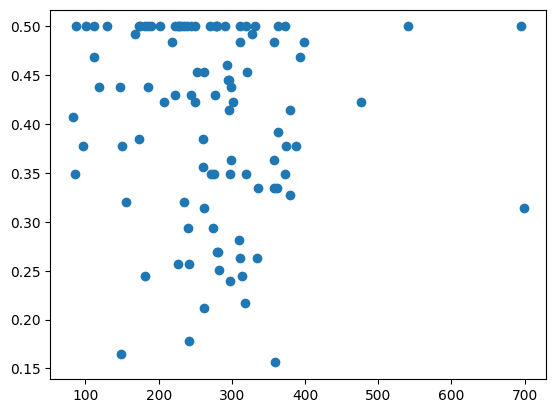

In [188]:
plt.scatter([x["open_count"][0] for x in results], [x["win_rate"] for x in results])

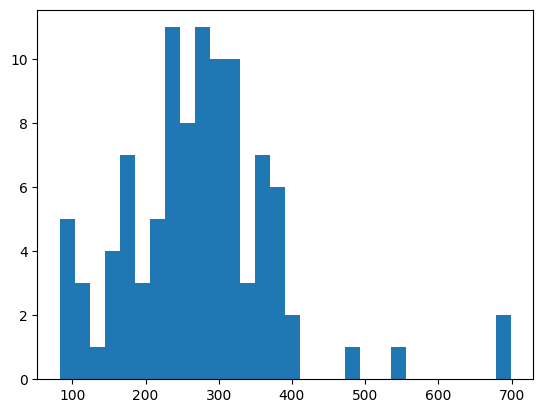

In [189]:
plt.hist([x["open_count"][0] for x in results],bins=30)
plt.show()

In [190]:
avg_stop_time = int(np.mean([x["open_count"][0] for x in results]))

np.mean([x["win_rate"] for x in results]), np.median([x["win_rate"] for x in results]), np.mean([x["open_count"][0] for x in results])

(0.4034264992315714, 0.43014734858584286, 272.62)

(array([ 2.,  1.,  0.,  0.,  1.,  1.,  0.,  3.,  3.,  4.,  1.,  0.,  2.,
         2.,  3.,  3.,  6.,  1.,  2.,  6.,  1.,  1.,  2.,  7.,  4.,  5.,
         1.,  2.,  4., 32.]),
 array([0.1561049 , 0.16756807, 0.17903124, 0.19049441, 0.20195758,
        0.21342075, 0.22488392, 0.23634709, 0.24781026, 0.25927343,
        0.2707366 , 0.28219977, 0.29366294, 0.30512611, 0.31658928,
        0.32805245, 0.33951562, 0.35097879, 0.36244196, 0.37390513,
        0.3853683 , 0.39683147, 0.40829464, 0.41975781, 0.43122098,
        0.44268415, 0.45414732, 0.46561049, 0.47707366, 0.48853683,
        0.5       ]),
 <BarContainer object of 30 artists>)

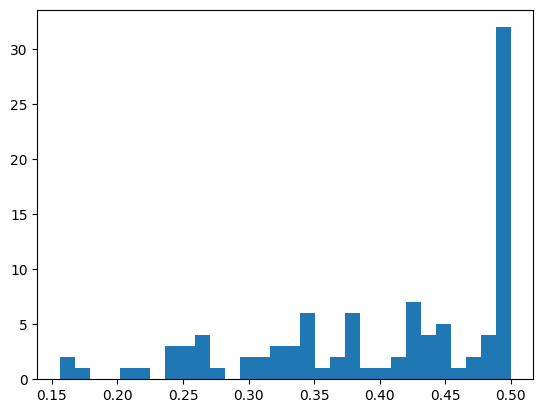

In [191]:
plt.hist([x["win_rate"] for x in results], bins=30)

0.38168248873007704 0.39983511510651926


(array([ 2.,  1.,  1.,  3.,  1.,  0.,  2.,  2.,  5.,  3.,  2.,  2.,  0.,
         2.,  1.,  3.,  4.,  4.,  3.,  4.,  4.,  1.,  4.,  3.,  5.,  1.,
         4.,  1.,  3., 29.]),
 array([0.13660839, 0.14872144, 0.1608345 , 0.17294755, 0.1850606 ,
        0.19717366, 0.20928671, 0.22139977, 0.23351282, 0.24562587,
        0.25773893, 0.26985198, 0.28196503, 0.29407809, 0.30619114,
        0.3183042 , 0.33041725, 0.3425303 , 0.35464336, 0.36675641,
        0.37886946, 0.39098252, 0.40309557, 0.41520862, 0.42732168,
        0.43943473, 0.45154779, 0.46366084, 0.47577389, 0.48788695,
        0.5       ]),
 <BarContainer object of 30 artists>)

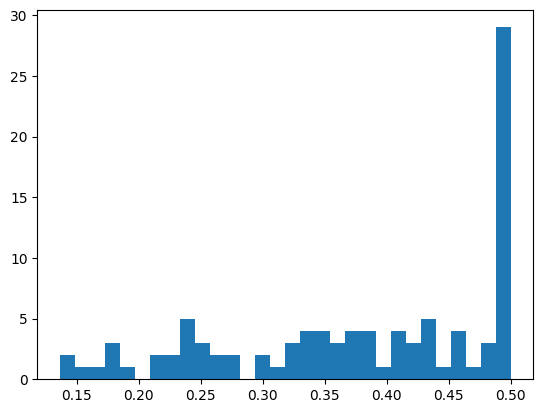

In [192]:
wins = []
df_real = data[generator_id]
for i in range(100):
    d = np.exp(df_real.iloc[i])
    v = np.max(d[:avg_stop_time])
    m = np.max(d)
    wins.append(v/(v+m))
print(np.mean(wins), np.median(wins))
plt.hist(wins, bins=30)

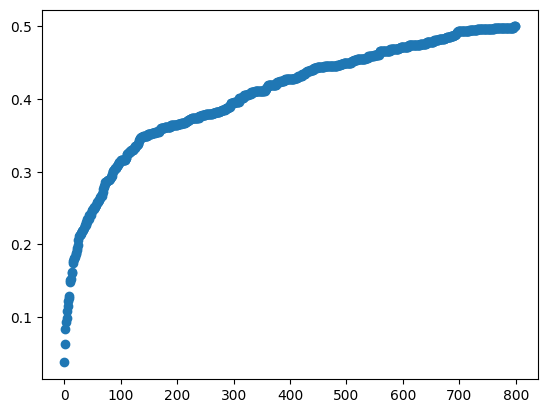

In [152]:
da = np.exp(np.array(df_real))
dm = np.max(da, axis=1)
wrs = []
for i in range(800):
    dv = np.max(da[:, :i+1], axis=1)
    wr = np.mean(dv/(dv+dm))
    
    wrs.append(wr)
plt.scatter(list(range(800)), wrs)